In [1]:
# modules
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

In [2]:
# read data
df = pd.read_csv('data_semi_train_clean.csv')
X = df.iloc[:,1:]
Y = (df['Label']=='defect').values+1-1

In [3]:
# normalization
from sklearn.preprocessing import StandardScaler
f = StandardScaler()
X = f.fit_transform(X)

In [4]:
# validation set
xtrain, xval, ytrain, yval = train_test_split(X,Y,test_size=0.2,random_state=0)
xtrain_n = xtrain[ytrain==0]

In [5]:
########################################################
# PCA
########################################################

from sklearn.decomposition import PCA
f = PCA()
f.fit(xtrain_n)

PCA()

col_0,0,1
row_0,,
False,8316,457
True,265,134


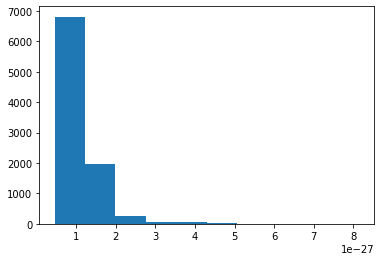

In [6]:
xtrain_r = f.inverse_transform(f.transform(xtrain))
dist = ((xtrain-xtrain_r)**2).sum(axis=1)
plt.hist(dist)
pd.crosstab(dist>0.2e-26,ytrain)

col_0,0,1
row_0,,
False,2079,115
True,67,33


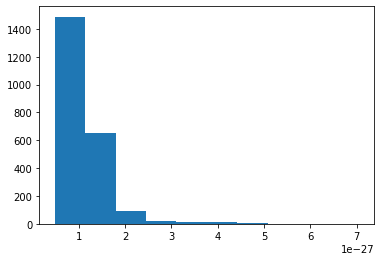

In [7]:
xval_r = f.inverse_transform(f.transform(xval))
dist = ((xval-xval_r)**2).sum(axis=1)
plt.hist(dist)
pd.crosstab(dist>0.2e-26,yval)

In [8]:
########################################################
# kmeans clustering
########################################################

from sklearn.cluster import KMeans
f = KMeans(n_clusters=100)
f.fit(xtrain_n)

KMeans(n_clusters=100)

In [9]:
d = f.transform(xtrain)
dist = d.min(axis=1)
pd.crosstab(dist>15,ytrain)

col_0,0,1
row_0,,
False,6591,154
True,1990,437


In [10]:
d = f.transform(xval)
dist = d.min(axis=1)
pd.crosstab(dist>15,yval)

col_0,0,1
row_0,,
False,1536,46
True,610,102


In [11]:
########################################################
# Gaussian Mixture
########################################################

from sklearn.mixture import GaussianMixture
f = GaussianMixture(n_components=100)
f.fit(xtrain_n)

GaussianMixture(n_components=100)

In [12]:
d = f.predict_proba(xtrain)
dist = d.max(axis=1)
pd.crosstab(dist<0.999,ytrain)

col_0,0,1
row_0,,
False,8581,591


In [13]:
d = f.predict_proba(xval)
dist = d.max(axis=1)
pd.crosstab(dist<0.999,yval)

col_0,0,1
row_0,,
False,2146,148


(array([   0.,    0.,    0.,    0.,    0., 2294.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

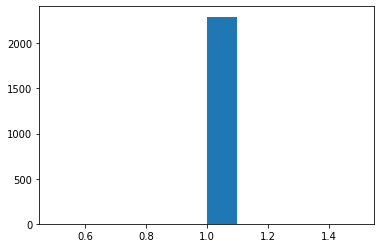

In [14]:
plt.hist(dist)

In [15]:
########################################################
# 1-SVM
########################################################

from sklearn.svm import OneClassSVM
f = OneClassSVM(nu=0.001)
f.fit(xtrain_n)

OneClassSVM(nu=0.001)

In [16]:
dist = f.decision_function(xtrain)
pd.crosstab(dist<0,ytrain)

col_0,0,1
row_0,,
False,8435,434
True,146,157


In [17]:
dist = f.decision_function(xval)
pd.crosstab(dist<0,yval)

col_0,0,1
row_0,,
False,2063,117
True,83,31


(array([  2.,  12.,  31., 119., 266., 484., 752., 488., 134.,   6.]),
 array([-0.18156046, -0.13273254, -0.08390461, -0.03507668,  0.01375125,
         0.06257918,  0.11140711,  0.16023504,  0.20906297,  0.2578909 ,
         0.30671883]),
 <BarContainer object of 10 artists>)

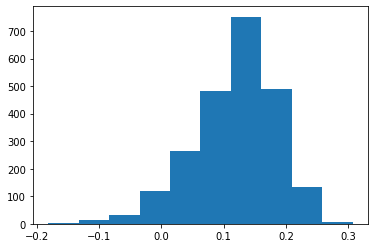

In [18]:
plt.hist(dist)

In [20]:
########################################################
# Autoencoder
########################################################
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [21]:
# read data
df = pd.read_csv('data_semi_train_clean.csv')
X = df.iloc[:,1:]
Y = (df['Label']=='defect').values+1-1

In [22]:
# normalization
from sklearn.preprocessing import MinMaxScaler
f = MinMaxScaler()
X = f.fit_transform(X)

In [23]:
# validation set
xtrain, xval, ytrain, yval = train_test_split(X,Y,test_size=0.2,random_state=0)
xtrain_n = xtrain[ytrain==0]
xval_n = xval[yval==0]

In [24]:
# autoencoder
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(500,activation='relu'),
      layers.Dense(latent_dim,activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(500,activation='relu'),     
      layers.Dense(303, activation='relu'),
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [25]:
f = Autoencoder(120)
f.compile(optimizer='adam', loss=losses.MeanSquaredError())
f.fit(xtrain_n,xtrain_n,epochs=50,shuffle=True,validation_data=(xval_n,xval_n))

Epoch 1/50
269/269 [==============================] - 1s 4ms/step - loss: 0.0389 - val_loss: 0.0245
Epoch 2/50
269/269 [==============================] - 1s 4ms/step - loss: 0.0162 - val_loss: 0.0119
Epoch 3/50
269/269 [==============================] - 1s 4ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 4/50
269/269 [==============================] - 1s 4ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 5/50
269/269 [==============================] - 1s 4ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 6/50
269/269 [==============================] - 1s 4ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 7/50
269/269 [==============================] - 1s 4ms/step - loss: 0.0074 - val_loss: 0.0080
Epoch 8/50
269/269 [==============================] - 1s 4ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 9/50
269/269 [==============================] - 1s 4ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 10/50
269/269 [==============================] - 1s 4ms/step - loss: 0.0063 - val_loss: 0.0065

col_0,0,1
row_0,,
False,8261,227
True,320,364


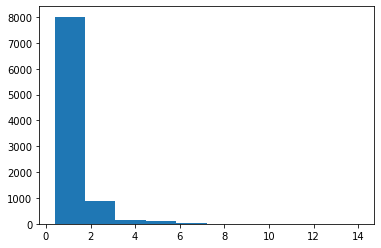

In [26]:
xtrain_r = f.decoder(f.encoder(xtrain)).numpy()
dist = ((xtrain-xtrain_r)**2).sum(axis=1)
plt.hist(dist)
pd.crosstab(dist>2,ytrain)

col_0,0,1
row_0,,
False,1972,58
True,174,90


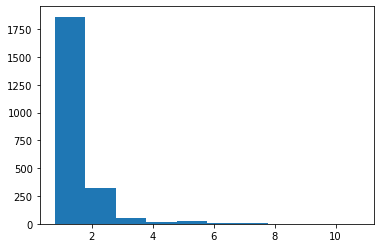

In [28]:
xval_r = f.decoder(f.encoder(xval)).numpy()
dist = ((xval-xval_r)**2).sum(axis=1)
plt.hist(dist)
pd.crosstab(dist>2,yval)